In [60]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import tqdm

## General parameters

We'll use the WGS 84 coordinate reference system (CRS) for all geographic data in this notebook, except when 
measuring distances

In [61]:
std_crs = "WGS84"

## Load GADM data

In [62]:
gadm_path = "../data/gadm_410_europe.gpkg"
stations_path = "../data/ECA_blend_tx/stations.txt"

In [63]:
gadm_gdf = gpd.read_file(gadm_path)
print(f"{gadm_gdf.shape=}")
gadm_gdf.head()

gadm_gdf.shape=(106252, 21)


,UID,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,ENGTYPE_2,GID_3,...,ENGTYPE_3,GID_4,NAME_4,ENGTYPE_4,GID_5,NAME_5,ENGTYPE_5,COUNTRY,CONTINENT,geometry
0,333,ALA,Åland,ALA.1_2,Archipelago,Sub-Region,ALA.1.1_2,Brändö,Municipality,,...,,,,,,,,Åland,Europe,"MULTIPOLYGON (((20.98333 60.64167, 20.98125 60..."
1,334,ALA,Åland,ALA.1_2,Archipelago,Sub-Region,ALA.1.2_2,Föglö,Municipality,,...,,,,,,,,Åland,Europe,"MULTIPOLYGON (((20.60028 59.81311, 20.60027 59..."
2,335,ALA,Åland,ALA.1_2,Archipelago,Sub-Region,ALA.1.3_2,Kökar,Municipality,,...,,,,,,,,Åland,Europe,"MULTIPOLYGON (((20.83333 60.03333, 20.83301 60..."
3,336,ALA,Åland,ALA.1_2,Archipelago,Sub-Region,ALA.1.4_2,Kumlinge,Municipality,,...,,,,,,,,Åland,Europe,"MULTIPOLYGON (((20.76042 60.46667, 20.75833 60..."
4,337,ALA,Åland,ALA.1_2,Archipelago,Sub-Region,ALA.1.1_2,Sottunga,Municipality,,...,,,,,,,,Åland,Europe,"MULTIPOLYGON (((20.56875 60.18333, 20.56667 60..."


In [64]:
all_countries = gadm_gdf["NAME_0"].unique()
print(f"All countries in the dataset ({len(all_countries)}):\n{all_countries}")

All countries in the dataset (54):
['Åland' 'Albania' 'Andorra' 'Austria' 'Azerbaijan' 'Belarus' 'Belgium'
 'Bosnia and Herzegovina' 'Bulgaria' 'Croatia' 'Czechia' 'Denmark'
 'Estonia' 'Faroe Islands' 'Finland' 'France' 'Germany' 'Greece'
 'Guernsey' 'Hungary' 'Iceland' 'Ireland' 'Isle of Man' 'Italy' 'Jersey'
 'Kazakhstan' 'Kosovo' 'Latvia' 'Liechtenstein' 'Lithuania' 'Luxembourg'
 'Malta' 'Moldova' 'Monaco' 'Montenegro' 'Netherlands' 'North Macedonia'
 'Norway' 'Poland' 'Portugal' 'Romania' 'Russia' 'San Marino' 'Serbia'
 'Slovakia' 'Slovenia' 'Spain' 'Svalbard and Jan Mayen' 'Sweden'
 'Switzerland' 'Turkey' 'Ukraine' 'United Kingdom' 'Vatican City']


In [65]:
countries_gadms = gadm_gdf.groupby("NAME_0")

In [66]:
def read_station_df(path: str) -> pd.DataFrame:
    station_df = pd.read_csv(
        path,
        skiprows=20,
        skipinitialspace=True,
        engine="c",
        parse_dates=["DATE"],
    )
    # Convert DATE column to datetime
    station_df["DATE"] = pd.to_datetime(station_df["DATE"], format="%Y%m%d")

    # Convert from tenths of degree C to degree C
    station_df["TX"] = station_df["TX"] / 10.0

    # Where Q_TX is 9, set TX to NaN
    station_df = station_df[station_df["Q_TX"] == 0]
    station_df.drop(columns=["Q_TX"], inplace=True)

    return station_df

In [67]:
def dms_to_decimal_vectorized(dms_series):
    """Vectorized DMS to decimal conversion for better performance."""
    # Extract sign
    signs = np.where(dms_series.str[0] == '+', 1, -1)

    # Remove sign and split by ':'
    parts = dms_series.str[1:].str.split(':', expand=True).astype(float)

    # Calculate decimal degrees
    decimal = signs * (parts[0] + parts[1]/60 + parts[2]/3600)

    return decimal

In [68]:
stations_df = pd.read_csv(stations_path, skiprows=17, skipinitialspace=True)

# Use vectorized DMS conversion
stations_df["LAT_decimal"] = dms_to_decimal_vectorized(stations_df["LAT"])
stations_df["LON_decimal"] = dms_to_decimal_vectorized(stations_df["LON"])

stations_df.head()

# Create GeoDataFrame directly without intermediate variable
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df["LON_decimal"], stations_df["LAT_decimal"]),
    crs="EPSG:4326"
)
stations_gdf.drop(columns=["LAT", "LON", "LAT_decimal", "LON_decimal"], inplace=True)

stations_gdf.head()

,STAID,STANAME,CN,HGHT,geometry
0,1,VAEXJOE,SE,166,POINT (14.8 56.86667)
1,2,FALUN,SE,160,POINT (15.61667 60.61667)
2,3,STENSELE,SE,325,POINT (17.16639 65.06667)
3,4,LINKOEPING,SE,93,POINT (15.53306 58.4)
4,5,LINKOEPING-MALMSLAETT,SE,93,POINT (15.53306 58.4)


In [69]:
# Convert stations to standard CRS once
stations_wdcrs = stations_gdf.to_crs(std_crs)
# Also convert GADM to standard CRS once for efficient spatial joins
gadm_gdf_std = gadm_gdf.to_crs(std_crs)
stations_wdcrs.head()

,STAID,STANAME,CN,HGHT,geometry
0,1,VAEXJOE,SE,166,POINT (14.8 56.86667)
1,2,FALUN,SE,160,POINT (15.61667 60.61667)
2,3,STENSELE,SE,325,POINT (17.16639 65.06667)
3,4,LINKOEPING,SE,93,POINT (15.53306 58.4)
4,5,LINKOEPING-MALMSLAETT,SE,93,POINT (15.53306 58.4)


In [70]:
# Optimized spatial join: use pre-converted CRS to avoid repeated conversions
countries_stations = gpd.sjoin(
    stations_wdcrs,
    gadm_gdf_std[['NAME_0', 'geometry']],
    how='inner',
    predicate='within'
)
countries_stations.reset_index()

,index,STAID,STANAME,CN,HGHT,geometry,index_right,NAME_0
0,0,1,VAEXJOE,SE,166,POINT (14.8 56.86667),93460,Sweden
1,1,2,FALUN,SE,160,POINT (15.61667 60.61667),93393,Sweden
2,2,3,STENSELE,SE,325,POINT (17.16639 65.06667),93601,Sweden
3,3,4,LINKOEPING,SE,93,POINT (15.53306 58.4),93491,Sweden
4,4,5,LINKOEPING-MALMSLAETT,SE,93,POINT (15.53306 58.4),93491,Sweden
...,...,...,...,...,...,...,...,...
7492,8563,28070,TRAPANI FONTANASALSA,IT,57,POINT (12.5525 37.94167),70656,Italy
7493,8564,28071,TRAPANI FULGATORE,IT,190,POINT (12.66139 37.9475),70656,Italy
7494,8565,28072,DUGURDSKAMPEN BH3,NO,1546,POINT (8.38583 61.69667),73128,Norway
7495,8566,28075,CANTONIGROS,ES,925,POINT (2.40444 42.0425),90193,Spain


In [71]:
# number of stations per country
countries_station_count = (
    countries_stations.groupby("NAME_0")
    .size()
    .rename("num_stations")
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"NAME_0": "country"})  # Rename for consistency
)
countries_station_count

,country,num_stations
0,Italy,1111
1,Germany,1041
2,Spain,921
3,Norway,900
4,Sweden,794
5,Austria,763
6,Finland,355
7,Poland,334
8,Russia,265
9,Hungary,169


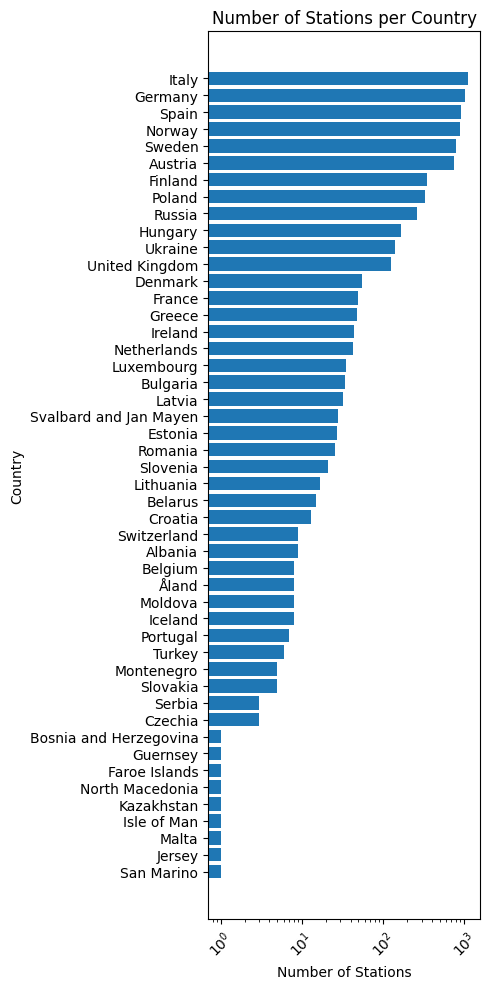

In [72]:
# display a horizontal bar chart of number of stations per country

plt.figure(figsize=(5, 10))
plt.barh(
    countries_station_count["country"][::-1],
    countries_station_count["num_stations"][::-1],
)

plt.ylabel("Country")
plt.xlabel("Number of Stations")
plt.xscale("log")
plt.title("Number of Stations per Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [73]:
countries_level2_gadm = {}
for country, country_gadm in tqdm.tqdm(countries_gadms, desc="Processing countries"):
    countries_level2_gadm[country] = country_gadm.dissolve("GID_1", method="coverage")

Processing countries: 100%|██████████| 54/54 [00:17<00:00,  3.13it/s]


100%|██████████| 54/54 [02:05<00:00,  2.33s/it]



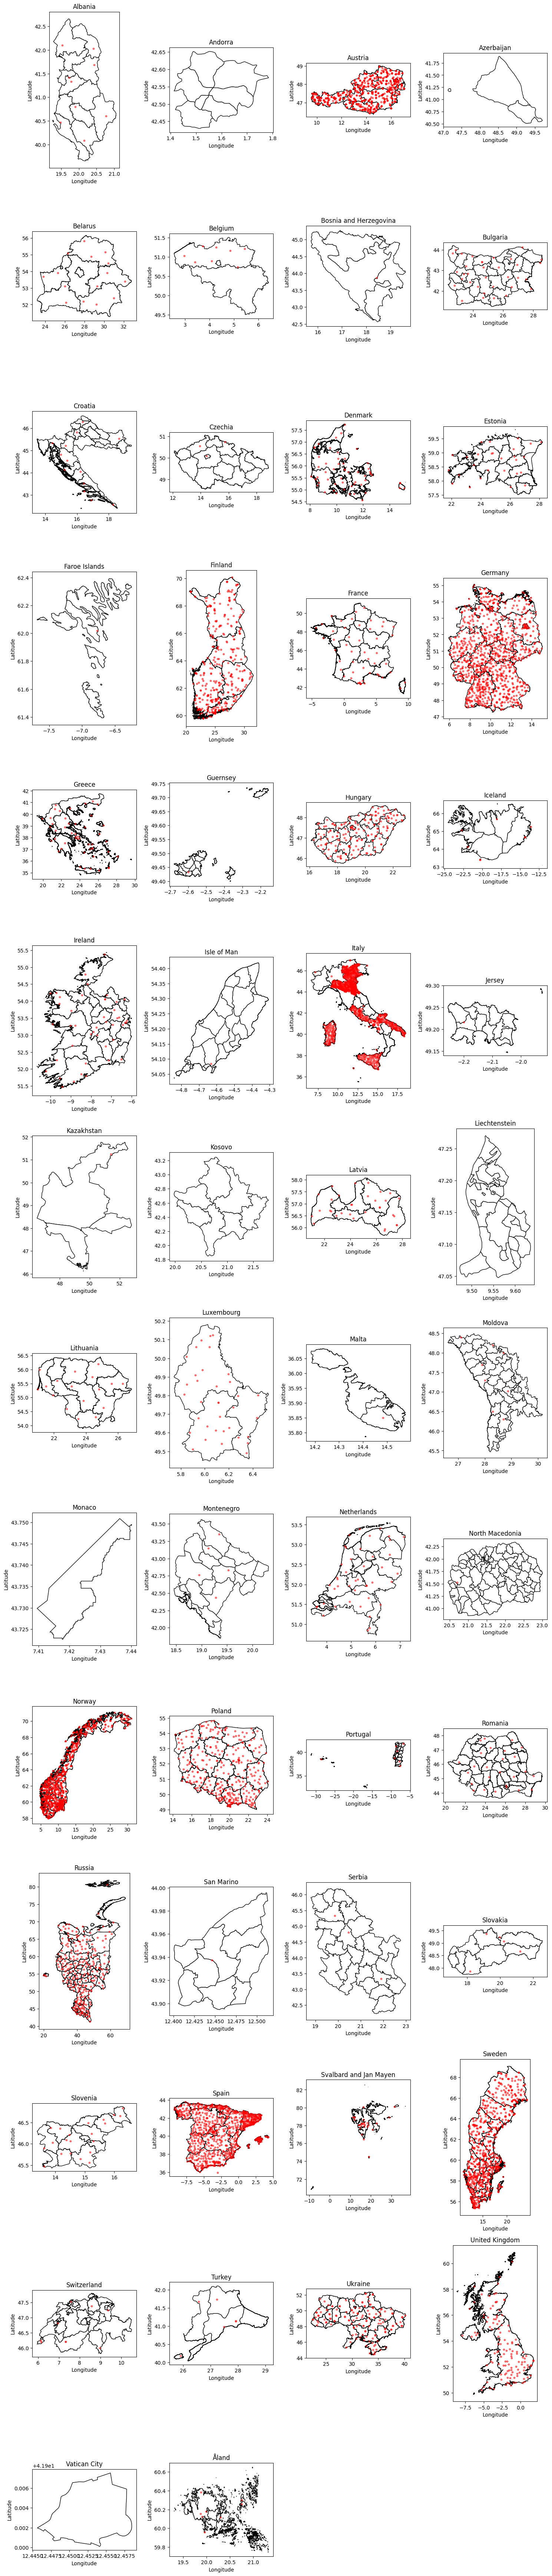

In [74]:
ncols = 4
nrows = int(np.ceil(len(countries_level2_gadm) / ncols))

fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axis = axis.flatten()

# Pre-filter countries_stations by country for efficiency
countries_stations_dict = {
    country: countries_stations[countries_stations['NAME_0'] == country]
    for country in countries_level2_gadm.keys()
}

for i, (country, level2_gadm) in tqdm.tqdm(
    enumerate(countries_level2_gadm.items()), total=len(countries_level2_gadm)
):
    ax = axis[i]
    level2_gadm.plot(color="white", edgecolor="black", ax=ax)

    # Use pre-filtered data
    country_data = countries_stations_dict[country]
    ax.scatter(
        country_data["geometry"].x,
        country_data["geometry"].y,
        color="red",
        s=10,
        alpha=0.5,
    )

    ax.set_title(country)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

for j in range(i + 1, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

In [75]:
# Optimize area calculation: dissolve is already done in countries_level2_gadm
countries_sizes = pd.DataFrame({
    "country": list(countries_level2_gadm.keys()),
    "size_km2": [
        country_gadm.to_crs(epsg=3395).geometry.area.sum() / 1e6
        for country_gadm in countries_level2_gadm.values()
    ]  # convert from m^2 to km^2
})
countries_sizes.head()

,country,size_km2
0,Albania,50520.198698
1,Andorra,828.494569
2,Austria,183910.100912
3,Azerbaijan,16450.861161
4,Belarus,584634.793119


In [76]:
# Use merge instead of join for better performance
countries_stations_size = countries_station_count.merge(
    countries_sizes, on="country", how="left"
)

countries_stations_size["stations_per_1000_km2"] = (
    countries_stations_size["num_stations"] / countries_stations_size["size_km2"]
) * 1000.0

countries_stations_size.sort_values(
    "stations_per_1000_km2", inplace=True, ascending=False
)

selected_countries = countries_stations_size[
    (countries_stations_size["num_stations"] > 100)
    & (countries_stations_size["size_km2"] > 500_000)
].iloc[:10].reset_index(drop=True)

selected_countries

,country,num_stations,size_km2,stations_per_1000_km2
0,Italy,1111,5.589442e+05,1.987676
1,Germany,1041,9.065714e+05,1.148282
2,Spain,921,8.583977e+05,1.072929
3,Norway,900,1.789487e+06,0.502937
4,Poland,334,8.267868e+05,0.403974
5,Sweden,794,2.178067e+06,0.364543
6,Finland,355,1.828697e+06,0.194127
7,United Kingdom,126,7.158318e+05,0.176019
8,Ukraine,141,1.395034e+06,0.101073
9,Russia,265,1.598131e+07,0.016582


In [77]:
print("Countries selected for the analysis:")
display(selected_countries)
print(f"Total stations: {selected_countries['num_stations'].sum():_}")
print(f"Total area (km^2): {selected_countries['size_km2'].sum():_.0f} km^2")

Countries selected for the analysis:


,country,num_stations,size_km2,stations_per_1000_km2
0,Italy,1111,5.589442e+05,1.987676
1,Germany,1041,9.065714e+05,1.148282
2,Spain,921,8.583977e+05,1.072929
3,Norway,900,1.789487e+06,0.502937
4,Poland,334,8.267868e+05,0.403974
5,Sweden,794,2.178067e+06,0.364543
6,Finland,355,1.828697e+06,0.194127
7,United Kingdom,126,7.158318e+05,0.176019
8,Ukraine,141,1.395034e+06,0.101073
9,Russia,265,1.598131e+07,0.016582


Total stations: 5_988
Total area (km^2): 27_039_129 km^2


In [84]:
# Filter countries_stations efficiently using isin
selected_stations = countries_stations[
    countries_stations["NAME_0"].isin(selected_countries["country"])
].reset_index(drop=True)

assert selected_stations.shape[0] == selected_countries["num_stations"].sum(), (
    "Number of selected stations does not match the sum of stations in selected countries."
)

print("Number of selected stations:", selected_stations.shape[0])

Number of selected stations: 5988


In [79]:
# eca_tx_datafolder = "../data/ECA_blend_tx/"

# station_paths = [
#     os.path.join(eca_tx_datafolder, f"TX_STAID{id:06d}.txt")
#     for id in selected_stations["STAID"]
# ]

# stations_list = [read_station_df(path) for path in tqdm.tqdm(station_paths)]

# region_station_data = pd.concat(stations_list, ignore_index=True)
# region_station_data.to_parquet("../processed/selected_countries_tx_data.parquet")

# print(f"Total number of records for region {gadm_filter}: {len(region_station_data)}")
# display(region_station_data.head())

In [80]:
region_station_data = pd.read_parquet("../processed/selected_countries_tx_data.parquet")

print(f"Total number of records for selected region: {len(region_station_data)}")
display(region_station_data.head())

,STAID,SOUID,DATE,TX
0,170,916133,2005-12-01,7.7
1,170,916133,2005-12-02,6.2
2,170,916133,2005-12-03,10.6
3,170,916133,2005-12-04,6.2
4,170,916133,2005-12-05,7.1


Total number of records for selected region: 83561206


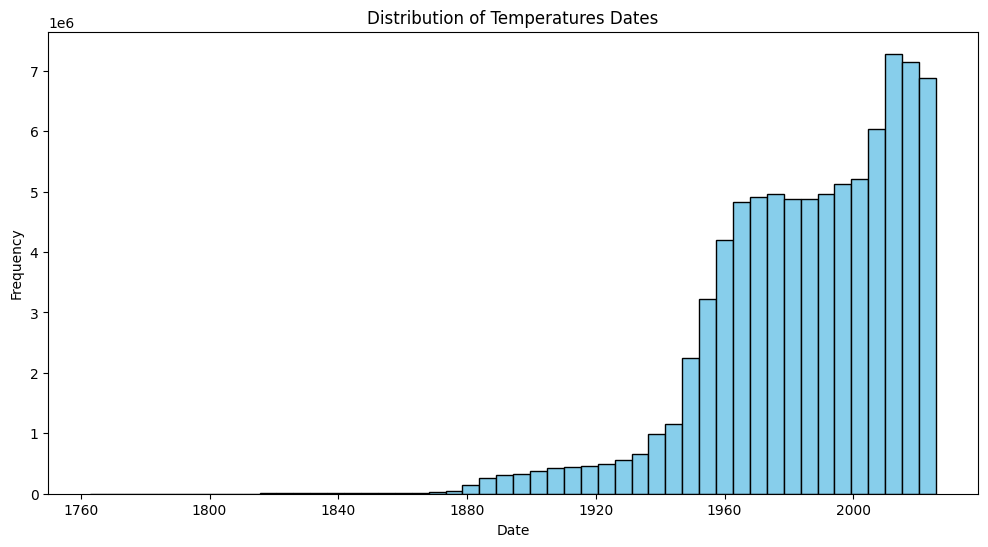

In [81]:
# analyze the tx time distribution
plt.figure(figsize=(12, 6))
plt.hist(region_station_data["DATE"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Distribution of Temperatures Dates")
plt.show()

In [87]:
selected_tx_data = region_station_data[region_station_data["DATE"] >= "2010-01-01"]
print(f"Total number of records from 2010 onwards: {len(selected_tx_data):_}")

Total number of records from 2010 onwards: 21_180_249


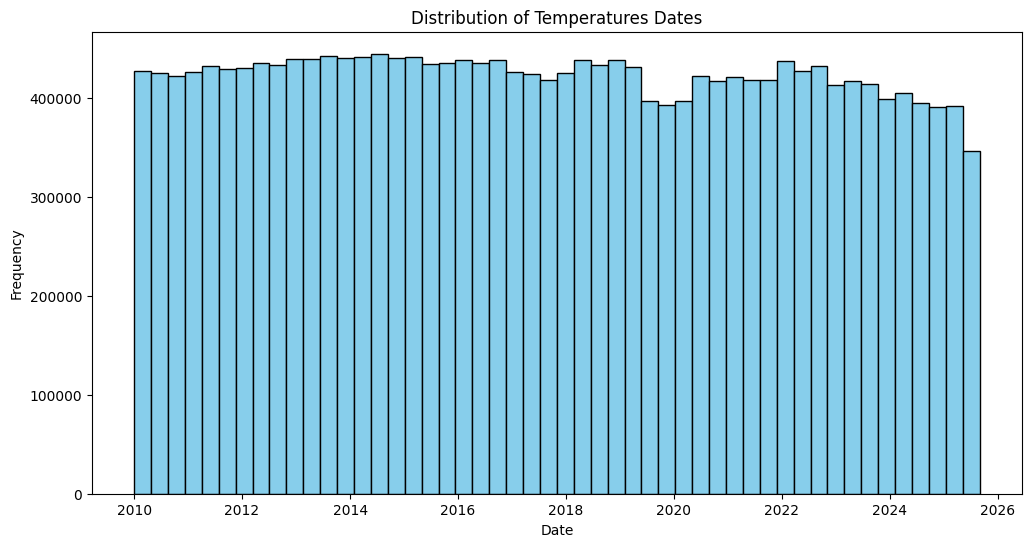

In [86]:
# analyze the tx time distribution
plt.figure(figsize=(12, 6))
plt.hist(selected_tx_data["DATE"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Distribution of Temperatures Dates")
plt.show()